In [2]:
# this notebook is to utilised transfer learning to train a model on a dataset to classify between cat and dog

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import time
import copy

In [3]:
# get root directory and label mapping
data_dir = '/media/victoru/B612CEC512CE8A37/ai50/pytorch_test/data/cats_and_dogs_filtered'
split_dir = os.listdir(data_dir)
label_dir = os.listdir(os.path.join(data_dir, split_dir[0]))
idx_to_class = {i: j for i, j in enumerate(label_dir)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

# create transform for data augmentation: normalize, and convert to tensor
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
size = 256
data_transforms = {
    split_dir[0]: transforms.Compose([
        transforms.RandomResizedCrop(size),
        transforms.RandomHorizontalFlip(), #add randomness to data augmentation
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    split_dir[1]: transforms.Compose([
        transforms.Resize(size),
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}
# define hyperparameters
batch_size = 10
num_epochs = 25

#show image
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

In [13]:
# create dataset and dataloader for training and validation
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in split_dir[:2]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in split_dir[:2]}

dataset_size = {x: len(image_datasets[x]) for x in split_dir[:2]}

class_names = image_datasets[split_dir[0]].classes

num_classes = len(class_names)

print(class_names)

['cats', 'dogs']


<class 'torch.Tensor'>
torch.Size([10, 3, 256, 256])


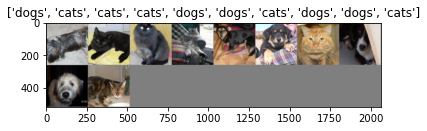

In [14]:
images, classes = next(iter(dataloaders[split_dir[1]]))
print(type(images))
print(images.shape)
imshow(torchvision.utils.make_grid(images), title = [class_names[x] for x in classes])

In [15]:
#setting up device to run on cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
#create training loop function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in split_dir[:2]:
            if phase == 'train':
                # set model to train mode for training phase
                model.train()
            else:
                # set model to evaluate mode for validation phase
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over databatchs for give phase
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # enable gradient computation when phase is train and forward pass for both phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward pass only if phase is train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model and update best_acc if phase is validation and epoch_acc is greater than best_acc
            if phase == split_dir[1] and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best Acc: {:.4f}'.format(best_acc))
            # adjust learning rate using scheduler if phase is validation
            if phase == split_dir[1]:
                print('Scheduler step')
                scheduler.step()
        print()

    # record time to train model
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
# fine tune model
# define fine tuned model as pretrained resnet18
model_ft = models.resnet18(pretrained=True)

# freeze all existing parameters
for param in model_ft.parameters():
    param.requires_grad = False

#get number of input features of last layer
num_features = model_ft.fc.in_features

#replace last layer with new layer with number of classes as output
model_ft.fc = nn.Linear(num_features, num_classes)

# set model to current device
model_ft = model_ft.to(device)

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001)

# setup scheduler for learning rate decay
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft, criterion, optimizer, step_lr_scheduler, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 0.5270 Acc: 0.7600
validation Loss: 0.2658 Acc: 0.9410
Best Acc: 0.9410
Scheduler step

Epoch 1/24
----------
train Loss: 0.3496 Acc: 0.8635
validation Loss: 0.1718 Acc: 0.9670
Best Acc: 0.9670
Scheduler step

Epoch 2/24
----------
train Loss: 0.3154 Acc: 0.8730
validation Loss: 0.1396 Acc: 0.9720
Best Acc: 0.9720
Scheduler step

Epoch 3/24
----------
train Loss: 0.3013 Acc: 0.8775
validation Loss: 0.1232 Acc: 0.9720
Scheduler step

Epoch 4/24
----------
train Loss: 0.2822 Acc: 0.8760
validation Loss: 0.1076 Acc: 0.9740
Best Acc: 0.9740
Scheduler step

Epoch 5/24
----------
train Loss: 0.2544 Acc: 0.8915
validation Loss: 0.0979 Acc: 0.9750
Best Acc: 0.9750
Scheduler step

Epoch 6/24
----------
train Loss: 0.2484 Acc: 0.9020
validation Loss: 0.0888 Acc: 0.9740
Scheduler step

Epoch 7/24
----------
train Loss: 0.2669 Acc: 0.8860
validation Loss: 0.0932 Acc: 0.9740
Scheduler step

Epoch 8/24
----------
train Loss: 0.2411 Acc: 0.9020
validation Loss: 0.088